Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['lm_head.weight', 'model.decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


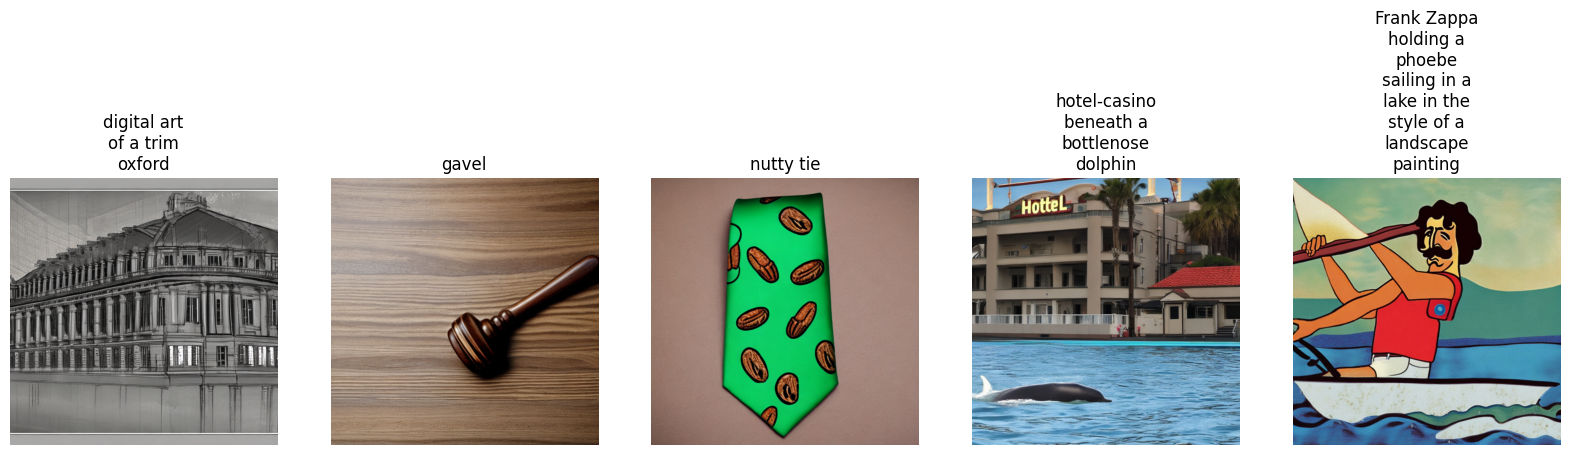

Step,Training Loss,Validation Loss,Wer Score
200,1.734600,1.218663,1.000000
400,0.958400,0.818105,1.127289
600,0.804100,0.960070,1.000000
800,0.805800,0.875690,0.947690
1000,0.727900,0.776253,0.955536
1200,0.650800,0.869154,0.878814
1400,0.674300,0.745464,0.900610
1600,0.665500,0.788619,0.836094
1800,0.639000,0.745540,0.799477
2000,0.634000,0.736462,0.883173


There were missing keys in the checkpoint model loaded: ['decoder.lm_head.weight'].


TrainOutput(global_step=9000, training_loss=0.5169603983561198, metrics={'train_runtime': 2886.6935, 'train_samples_per_second': 3.118, 'train_steps_per_second': 3.118, 'total_flos': 6.84677132439552e+17, 'train_loss': 0.5169603983561198, 'epoch': 10.0})

In [8]:
import os
os.environ['CURL_CA_BUNDLE'] = ''

import nltk
from datasets import load_dataset
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np
import torch

from transformers import (
    VisionEncoderDecoderModel,
    AutoFeatureExtractor,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
)
from evaluate import load

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Model selection
encoder_model = "microsoft/swin-tiny-patch4-window7-224"
decoder_model = "facebook/bart-base"

# Load model
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encoder_model, decoder_model)

# Processor & Tokenizer
image_processor = AutoFeatureExtractor.from_pretrained(encoder_model)
tokenizer = AutoTokenizer.from_pretrained(decoder_model)
tokenizer.pad_token = tokenizer.eos_token
ignore_pad_token_for_loss = True

# Update config
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# Metric
wer = load("wer")

# Plotting
def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

# Preprocessing
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]

    inputs = image_processor(images, return_tensors="pt")
    labels = tokenizer(captions, padding="max_length", max_length=128, truncation=True).input_ids
    inputs = {k: v for k, v in inputs.items()}
    inputs["labels"] = labels
    return inputs

# Postprocessing for metrics
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]
    return preds, labels

# WER metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, tuple):
        logits = logits[0]
    preds = logits.argmax(-1)

    if ignore_pad_token_for_loss:
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    wer_score = wer.compute(predictions=decoded_preds, references=decoded_labels)
    return {"wer_score": wer_score}

# Load dataset
ds = load_dataset("jpawan33/kag100-image-captioning-dataset")
ds = ds["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

train_ds.set_transform(transforms)
test_ds.set_transform(transforms)


# Training
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/SwinBART-kag100",
    learning_rate=5e-5,
    num_train_epochs=10,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    eval_strategy="steps", # Changed evaluation_strategy to eval_strategy
    eval_steps=200,
    save_strategy="steps", # Changed save_strategy to save_strategy
    save_steps=200,
    logging_steps=200,
    save_total_limit=3,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()


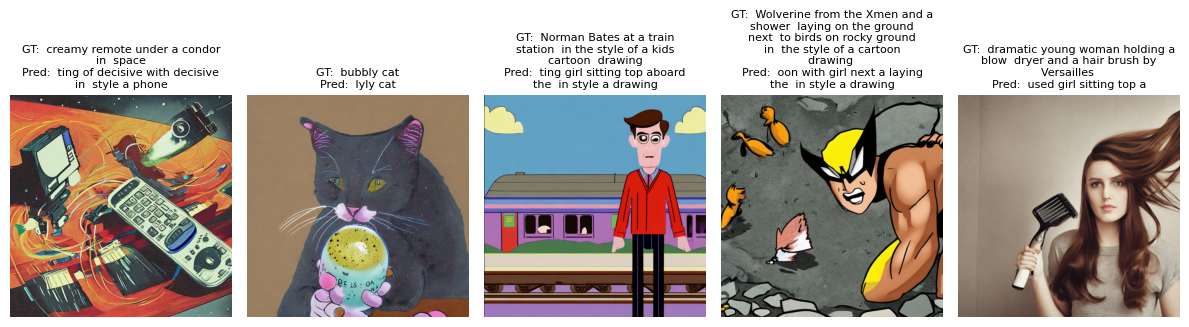

In [12]:
import os
os.environ['CURL_CA_BUNDLE'] = ''

import nltk
import torch
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
from datasets import load_dataset
from transformers import (
    VisionEncoderDecoderModel,
    AutoFeatureExtractor,
    AutoTokenizer,
)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model & processor
model = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/SwinBART-kag100/checkpoint-5200")
image_processor = AutoFeatureExtractor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
tokenizer.pad_token = tokenizer.eos_token

# Model config
model.to(device)
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# Helper functions
def wrap_text(text, max_width=30):
    words = text.split()
    wrapped_text = ""
    current_line = ""
    for word in words:
        if len(current_line + word) <= max_width:
            current_line += " " + word
        else:
            wrapped_text += current_line + "\n"
            current_line = word + " "
    wrapped_text += current_line
    return wrapped_text

def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

def plot_images_with_captions(images, ground_truth_captions, predicted_captions, figsize=(12, 6), max_width_caption=30):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=figsize)
    if num_images == 1:
        axes = [axes]

    for i, (image, ground_truth, prediction) in enumerate(zip(images, ground_truth_captions, predicted_captions)):
        ax = axes[i]
        ax.imshow(image)
        ax.axis('off')
        wrapped_ground_truth = wrap_text(ground_truth, max_width_caption)
        wrapped_prediction = wrap_text(prediction, max_width_caption)
        ax.set_title(f"GT: {wrapped_ground_truth}\nPred: {wrapped_prediction}", fontsize=8)

    plt.tight_layout()
    plt.show()

def get_caption(model, image_processor, tokenizer, image):
    img = image_processor(image, return_tensors="pt").to(device)
    output = model.generate(**img)
    caption = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
    return caption

# Load dataset
ds = load_dataset("jpawan33/kag100-image-captioning-dataset")
ds = ds["train"].train_test_split(test_size=0.1)
test_ds = ds["test"]

# Select sample images and captions
sample_images_to_visualize = [np.array(test_ds[i]["image"]) for i in range(5)]
sample_captions = [test_ds[i]["text"] for i in range(5)]

# Inference
pred_captions = []
for image in sample_images_to_visualize:
    caption = get_caption(model, image_processor, tokenizer, image)
    pred_captions.append(caption)

# Plot results
plot_images_with_captions(sample_images_to_visualize, sample_captions, pred_captions)


In [4]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 38.9 MB/s eta 0:00:00


In [2]:
#pip install datasets
!pip install transformers datasets evaluate torchvision pillow matplotlib nltk sentencepiece tqdm
import nltk
nltk.download('punkt')

import torch
print("GPU Available:", torch.cuda.is_available())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


GPU Available: True
